In [7]:
# !pip install reportlab

In [11]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from reportlab.lib.pagesizes import A4, landscape
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch, mm
from reportlab.lib.colors import black, blue, gray
from reportlab.lib.utils import ImageReader
import io
import os # เพิ่ม import os สำหรับจัดการไฟล์

def generate_static_map_image(location_coords=(13.7563, 100.5018), zoom=12, output_size_inches=(8, 6), debug_save_path=None):
    """
    Generates a static map image using GeoPandas and Contextily.

    Args:
        location_coords (tuple): (latitude, longitude) for the map center.
        zoom (int): Zoom level for the map tiles.
        output_size_inches (tuple): (width, height) in inches for the output image.
        debug_save_path (str, optional): If provided, saves the generated map to this path for debugging.

    Returns:
        io.BytesIO: A BytesIO object containing the map image data in PNG format.
    """
    # Create a dummy GeoDataFrame for the extent, or use your actual spatial data
    # For a specific location, we can define a small buffer
    gdf = gpd.GeoDataFrame({
        'geometry': [gpd.points_from_xy([location_coords[1]], [location_coords[0]])[0]],
        'name': ['Center']
    }, crs="EPSG:4326") # WGS84

    # Convert to a projected CRS that contextily works well with
    gdf_proj = gdf.to_crs(epsg=3857) # Web Mercator

    fig, ax = plt.subplots(figsize=output_size_inches, dpi=300) # Higher DPI for better quality
    
    # Plot the data (optional, e.g., if you have points, lines, polygons)
    # gdf_proj.plot(ax=ax, color='red', markersize=50) 
    
    # Add contextily basemap
    try:
        ctx.add_basemap(ax, crs=gdf_proj.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    except Exception as e:
        print(f"Error adding basemap (check internet or provider): {e}")
        # Fallback: create a blank plot if basemap fails
        ax.set_title("Map loading failed. Check internet connection.")
        ax.set_facecolor('lightgray')

    # Remove axis for a cleaner map
    ax.set_axis_off()
    
    # Adjust tight layout
    plt.tight_layout(pad=0)

    # Save the plot to a BytesIO object (in-memory)
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig) # Close the plot to free memory
    img_buffer.seek(0) # Rewind the buffer to the beginning

    # --- DEBUGGING STEP: Save to a file if debug_save_path is provided ---
    if debug_save_path:
        with open(debug_save_path, 'wb') as f:
            f.write(img_buffer.getvalue()) # getvalue() reads the whole content
        print(f"DEBUG: Map saved to {debug_save_path} for inspection.")
        # Rewind again for ImageReader if getvalue() moved pointer
        img_buffer.seek(0) 

    return img_buffer

def create_custom_report_template_with_generated_map(
    filename="report_template_generated_map.pdf", 
    map_location=(13.7563, 100.5018), # Bangkok, Thailand
    map_zoom=12
):
    # กำหนดขนาด A4 แนวนอน
    page_width, page_height = landscape(A4)
    c = canvas.Canvas(filename, pagesize=landscape(A4))

    # กำหนดระยะขอบ (margins) เพื่อให้มีพื้นที่รอบๆ เนื้อหา
    margin = 0.5 * inch # 0.5 นิ้ว
    
    # คำนวณพื้นที่ที่ใช้งานได้
    usable_width = page_width - (2 * margin)
    usable_height = page_height - (2 * margin)

    # --- ส่วนที่ 1: แผนที่ (2/3 ของหน้ากระดาษ) ---
    map_display_width = usable_width * (2/3)
    map_display_height = usable_height
    map_x = margin
    map_y = margin
    
    # Debugging print statements for map drawing area
    print(f"DEBUG: Map display area: x={map_x}, y={map_y}, width={map_display_width}, height={map_display_height}")
    print(f"DEBUG: Map display area (inches): width={map_display_width/inch:.2f} inches, height={map_display_height/inch:.2f} inches")


    # Generate the map image directly
    # Adjust output_size_inches to match the desired display size in PDF for good resolution
    # Convert points to inches for calculation (1 inch = 72 points in ReportLab default)
    map_image_buffer = generate_static_map_image(
        location_coords=map_location, 
        zoom=map_zoom, 
        output_size_inches=(map_display_width / inch, map_display_height / inch), # Pass width/height in inches
        debug_save_path="debug_map_output.png" # <--- IMPORTANT: This will save the map to a file for inspection
    )
    
    # ตรวจสอบว่า buffer มีข้อมูลหรือไม่
    if map_image_buffer.tell() == 0:
        print("ERROR: Map image buffer is empty. Map not generated correctly.")
        # Draw a placeholder text instead
        c.setFont("Helvetica-Bold", 16)
        c.setFillColor(black)
        c.drawString(map_x + 50, map_y + map_display_height / 2, "Map Not Available")
        c.drawString(map_x + 50, map_y + map_display_height / 2 - 20, "Check 'debug_map_output.png' and console for errors.")
    else:
        try:
            map_img_reader = ImageReader(map_image_buffer)
            # Draw the generated map image
            c.drawImage(map_img_reader, map_x, map_y, width=map_display_width, height=map_display_height)
        except Exception as e:
            print(f"ERROR: Could not draw map image in PDF: {e}")
            c.setFont("Helvetica-Bold", 16)
            c.setFillColor(black)
            c.drawString(map_x + 50, map_y + map_display_height / 2, "Map Drawing Error")
            c.drawString(map_x + 50, map_y + map_display_height / 2 - 20, f"Error: {e}")

    # Add a title for the map section
    c.setFont("Helvetica-Bold", 14)
    c.drawString(map_x + 10, map_y + map_display_height - 30, "แผนที่ภูมิประเทศ: (2/3 ของหน้ากระดาษ)")


    # --- ส่วนที่ 2: คำบรรยาย (1/3 ด้านข้างขวา - ส่วนบน) ---
    description_width = usable_width * (1/3)
    description_x = map_x + map_display_width + margin / 2 # ตำแหน่ง X ถัดจากแผนที่ + ช่องว่าง
    
    # คำนวณความสูงของส่วนคำบรรยาย (ประมาณ 3/4 ของ 1/3)
    description_height = usable_height * (3/4) 
    description_y = usable_height - description_height + margin # ตำแหน่ง Y เริ่มจากด้านล่างของหน้า

    # เพิ่มหัวข้อคำบรรยาย (สามารถปรับให้ใช้ Platypus.Paragraph ได้ถ้าเนื้อหายาวมาก)
    c.setFont("Helvetica-Bold", 16)
    c.setFillColor(blue)
    c.drawString(description_x + 10, description_y + description_height - 30, "รายละเอียด / คำบรรยาย")

    # เพิ่มเนื้อหาคำบรรยาย
    c.setFont("Helvetica", 10)
    c.setFillColor(black)
    description_text = [
        "ข้อมูลสำคัญเกี่ยวกับพื้นที่ในแผนที่ด้านซ้าย:",
        "ตำแหน่ง: ใจกลางกรุงเทพมหานคร",
        "เป็นพื้นที่ที่มีความหนาแน่นสูงและเป็นศูนย์กลางทางเศรษฐกิจ",
        "",
        "ในพื้นที่นี้มีอาคารสำคัญและสถานที่ท่องเที่ยวมากมาย",
        "รวมถึงการคมนาคมขนส่งที่หลากหลาย.",
        "",
        "ข้อมูลเพิ่มเติมอาจรวมถึงสถิติประชากร, การใช้ที่ดิน, หรือ",
        "ข้อมูลเฉพาะทางอื่นๆ ที่เกี่ยวข้องกับแผนที่."
    ]
    # วาดข้อความหลายบรรทัด
    textobject = c.beginText(description_x + 10, description_y + description_height - 50)
    textobject.setFont("Helvetica", 10)
    textobject.setFillColor(black)
    for line in description_text:
        textobject.textLine(line)
    c.drawText(textobject)


    # --- ส่วนที่ 3: เครดิตผู้จัดทำ (1/3 ด้านข้างขวา - ส่วนล่าง) ---
    credit_width = usable_width * (1/3)
    credit_x = description_x # ตำแหน่ง X เดียวกันกับคำบรรยาย
    credit_height = usable_height * (1/4) # ส่วนที่เหลือจากคำบรรยาย
    credit_y = margin # วางที่ส่วนล่างสุด

    # เพิ่มเนื้อหาเครดิต
    c.setFont("Helvetica-Bold", 12)
    c.setFillColor(black)
    c.drawString(credit_x + 10, credit_y + credit_height - 30, "ผู้จัดทำ:")
    c.setFont("Helvetica", 10)
    c.drawString(credit_x + 10, credit_y + credit_height - 50, "ชื่อ-นามสกุล: คุณเจมินี่ AI")
    c.drawString(credit_x + 10, credit_y + credit_height - 65, "ตำแหน่ง: ผู้ช่วยอัจฉริยะ")
    c.drawString(credit_x + 10, credit_y + credit_height - 80, "วันที่: 12 มิถุนายน 2568")

    # บันทึก PDF
    c.save()
    print(f"สร้างไฟล์ '{filename}' เรียบร้อยแล้ว")

if __name__ == "__main__":
    # ตรวจสอบให้แน่ใจว่าติดตั้งไลบรารีที่จำเป็น:
    # pip install geopandas contextily matplotlib
    create_custom_report_template_with_generated_map()

DEBUG: Map display area: x=36.0, y=36.0, width=513.2598425196851, height=523.2755905511812
DEBUG: Map display area (inches): width=7.13 inches, height=7.27 inches
DEBUG: Map saved to debug_map_output.png for inspection.
ERROR: Map image buffer is empty. Map not generated correctly.
สร้างไฟล์ 'report_template_generated_map.pdf' เรียบร้อยแล้ว


In [12]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import os

def test_map_generation(location_coords=(13.7563, 100.5018), zoom=12, output_filename="test_map.png"):
    """
    Generates a static map image for testing purposes.
    """
    print(f"Attempting to generate map at coords: {location_coords}, zoom: {zoom}")
    print(f"Output will be saved to: {output_filename}")

    # Create a dummy GeoDataFrame for the extent, or use your actual spatial data
    gdf = gpd.GeoDataFrame({
        'geometry': [gpd.points_from_xy([location_coords[1]], [location_coords[0]])[0]],
        'name': ['Center']
    }, crs="EPSG:4326") # WGS84

    # Convert to a projected CRS that contextily works well with
    gdf_proj = gdf.to_crs(epsg=3857) # Web Mercator

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300) # Standard size for testing
    
    try:
        ctx.add_basemap(ax, crs=gdf_proj.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
        print("Basemap added successfully.")
    except Exception as e:
        print(f"ERROR: Failed to add basemap. Please check your internet connection and try a different zoom level or provider.")
        print(f"Error details: {e}")
        ax.set_title("Map loading failed. Check internet connection or zoom.")
        ax.set_facecolor('lightgray')

    ax.set_axis_off()
    plt.tight_layout(pad=0)

    try:
        plt.savefig(output_filename, format='png', bbox_inches='tight', pad_inches=0)
        print(f"Map saved to {output_filename}")
    except Exception as e:
        print(f"ERROR: Failed to save map image to file: {e}")
    
    plt.close(fig) # Close the plot to free memory

if __name__ == "__main__":
    # Test 1: Using Bangkok coordinates and a moderate zoom
    print("\n--- Test 1: Bangkok, zoom 12 ---")
    test_map_generation(location_coords=(13.7563, 100.5018), zoom=12, output_filename="test_map_bangkok_z12.png")

    # Test 2: Using the same coordinates but a lower zoom (should show broader area)
    print("\n--- Test 2: Bangkok, zoom 8 ---")
    test_map_generation(location_coords=(13.7563, 100.5018), zoom=8, output_filename="test_map_bangkok_z8.png")

    # Test 3: Using the same coordinates but a higher zoom (may or may not show more detail depending on data availability)
    print("\n--- Test 3: Bangkok, zoom 16 ---")
    test_map_generation(location_coords=(13.7563, 100.5018), zoom=16, output_filename="test_map_bangkok_z16.png")

    # Test 4: Try a different map provider (sometimes default might have issues)
    # Check ctx.providers for more options. Common ones are Stamen.Toner, ESRI.WorldStreetMap
    print("\n--- Test 4: Bangkok, zoom 12, different provider (Stamen Toner) ---")
    
    # You'll need to modify the test_map_generation function temporarily for this,
    # or create a new test function as ctx.add_basemap source is hardcoded.
    # For now, manually try modifying source in the main function
    # In test_map_generation, change:
    # source=ctx.providers.OpenStreetMap.Mapnik
    # TO:
    # source=ctx.providers.Stamen.Toner
    
    # Rerun the script after changing provider source in the function
    # test_map_generation(location_coords=(13.7563, 100.5018), zoom=12, output_filename="test_map_bangkok_stamen.png")
    # Please revert the source back to OpenStreetMap.Mapnik after testing if you want to use the default
    
    print("\n-- Please check the generated 'test_map_*.png' files to see if maps are appearing. --")
    print("-- Also, check the console output for any 'ERROR' messages. --")


--- Test 1: Bangkok, zoom 12 ---
Attempting to generate map at coords: (13.7563, 100.5018), zoom: 12
Output will be saved to: test_map_bangkok_z12.png
Basemap added successfully.
Map saved to test_map_bangkok_z12.png

--- Test 2: Bangkok, zoom 8 ---
Attempting to generate map at coords: (13.7563, 100.5018), zoom: 8
Output will be saved to: test_map_bangkok_z8.png
Basemap added successfully.
Map saved to test_map_bangkok_z8.png

--- Test 3: Bangkok, zoom 16 ---
Attempting to generate map at coords: (13.7563, 100.5018), zoom: 16
Output will be saved to: test_map_bangkok_z16.png
Basemap added successfully.
Map saved to test_map_bangkok_z16.png

--- Test 4: Bangkok, zoom 12, different provider (Stamen Toner) ---

-- Please check the generated 'test_map_*.png' files to see if maps are appearing. --
-- Also, check the console output for any 'ERROR' messages. --


In [59]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt


In [60]:
data_url = "https://ndownloader.figshare.com/files/20232174"
db = gpd.read_file(data_url)
db.crs

/opt/anaconda3/envs/geoai/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsicurl/https://ndownloader.figshare.com/files/20232174 has GPKG application_id, but non conformant file extension
  return ogr_read(


<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - onshore and offshore.
- bounds: (-6.0, 35.26, 0.01, 80.49)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [61]:
# ax = db.plot(color="red", figsize=(9, 9))
# ctx.add_basemap(ax, crs=db.crs)

In [62]:
gdf = gpd.read_file('pm25.shp')
gdf

,latitude,longitude,value,geometry
0,13.732846,100.487662,23.2,POINT (100.48766 13.73285)
1,13.636514,100.414262,24.5,POINT (100.41426 13.63651)
2,13.775530,100.569195,20.8,POINT (100.5692 13.77553)
3,13.708067,100.547333,20.4,POINT (100.54733 13.70807)
4,13.729852,100.536501,24.2,POINT (100.5365 13.72985)
...,...,...,...,...
182,17.484620,101.732734,25.7,POINT (101.73273 17.48462)
183,18.128367,100.162433,34.6,POINT (100.16243 18.12837)
184,19.304550,97.971650,94.3,POINT (97.97165 19.30455)
185,19.359152,98.436479,79.2,POINT (98.43648 19.35915)


In [63]:
gdf_proj = gdf.to_crs(epsg=3857) # Web Mercator

In [64]:
gdf_proj

,latitude,longitude,value,geometry
0,13.732846,100.487662,23.2,POINT (11186235.365 1543584.36)
1,13.636514,100.414262,24.5,POINT (11178064.514 1532547.417)
2,13.775530,100.569195,20.8,POINT (11195311.577 1548476.196)
3,13.708067,100.547333,20.4,POINT (11192877.944 1540744.912)
4,13.729852,100.536501,24.2,POINT (11191672.097 1543241.263)
...,...,...,...,...
182,17.484620,101.732734,25.7,POINT (11324836.146 1977311.395)
183,18.128367,100.162433,34.6,POINT (11150031.072 2052579.113)
184,19.304550,97.971650,94.3,POINT (10906154.19 2190824.764)
185,19.359152,98.436479,79.2,POINT (10957898.762 2197266.243)


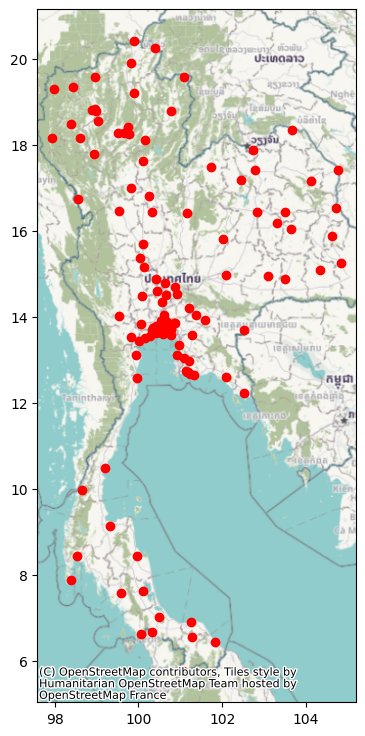

In [65]:
ax = gdf.plot(color="red", figsize=(9, 9))
ctx.add_basemap(ax, crs=gdf.crs)

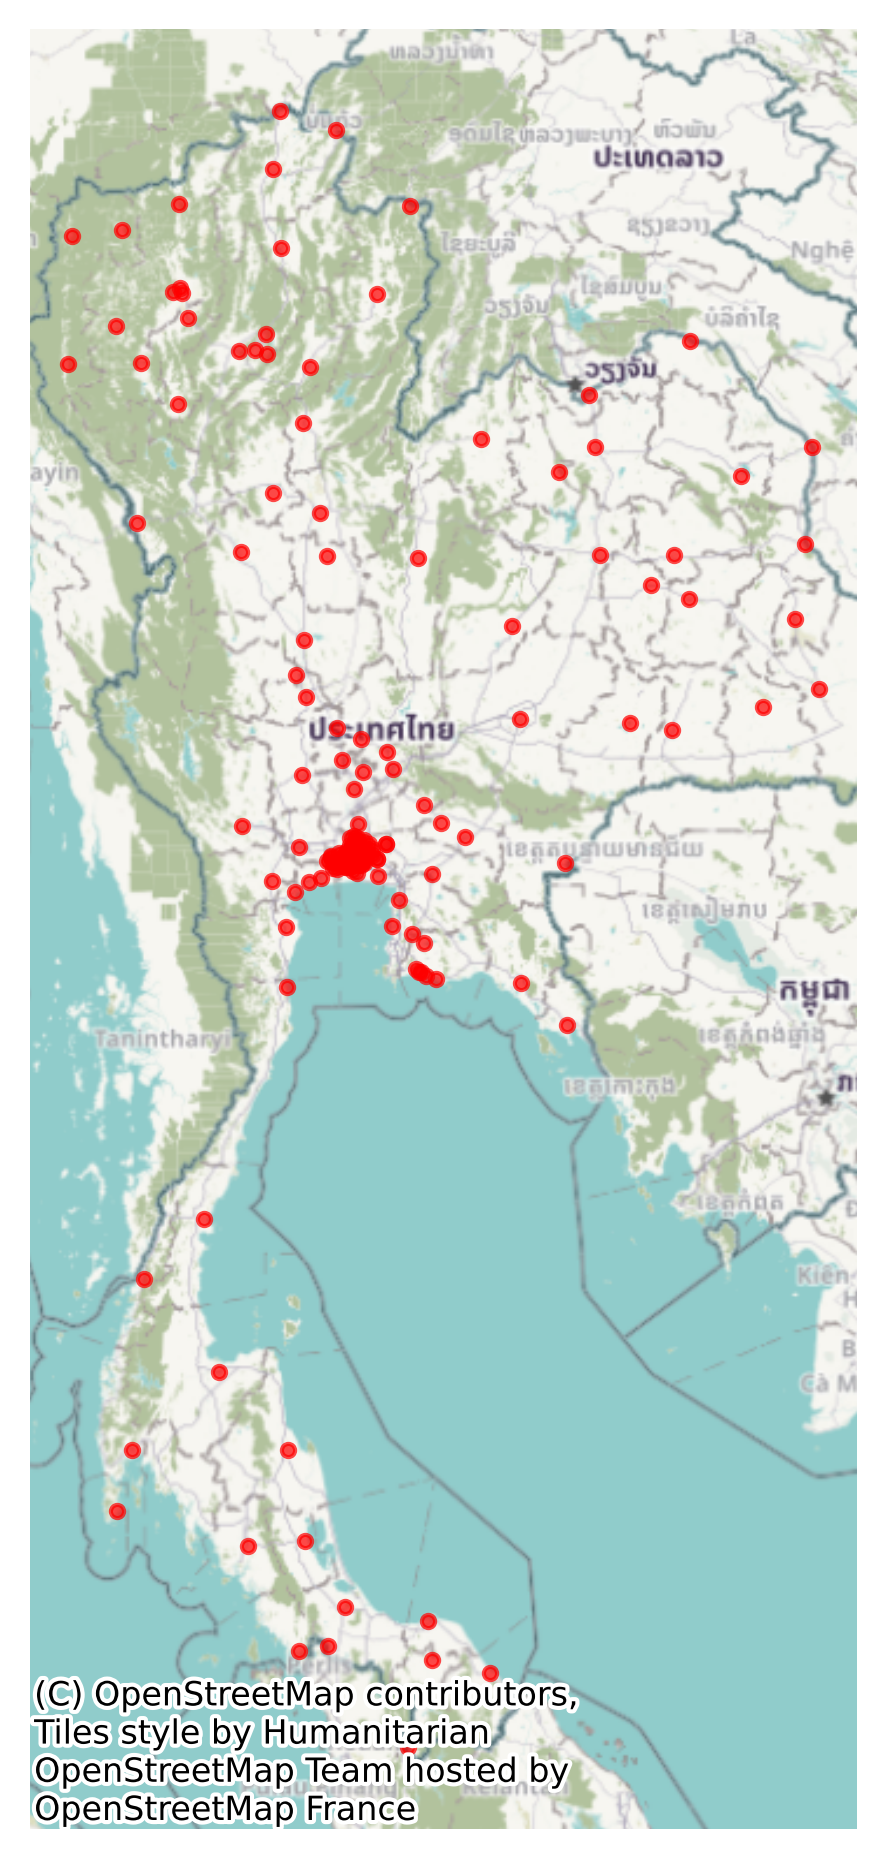

In [87]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
gdf.plot(ax=ax, color="red", markersize=10, alpha=0.7, zorder=2)
ctx.add_basemap(ax, crs=gdf.crs)
ax.set_axis_off()
plt.tight_layout(pad=0)

In [88]:
plt.show()

In [81]:
output_filename = 'ttt.png'
try:
    plt.savefig(output_filename, format='png', bbox_inches='tight', pad_inches=0)
    print(f"Map saved to {output_filename}")
except Exception as e:
    print(f"ERROR: Failed to save map image to file: {e}")

Map saved to ttt.png


<Figure size 640x480 with 0 Axes>

Basemap added successfully.


<Figure size 640x480 with 0 Axes>

[]

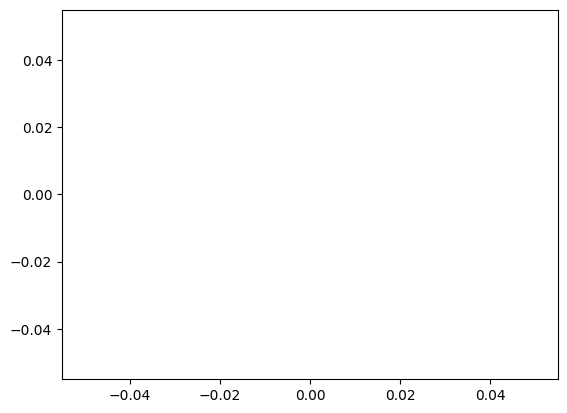

In [78]:
plt.plot()

In [74]:
output_filename = 'ttt.png'
try:
    plt.savefig(output_filename, format='png', bbox_inches='tight', pad_inches=0)
    print(f"Map saved to {output_filename}")
except Exception as e:
    print(f"ERROR: Failed to save map image to file: {e}")

Map saved to ttt.png


<Figure size 640x480 with 0 Axes>

--- Attempting to display map from pm25.shp in a window ---
SUCCESS: Loaded shapefile: pm25.shp with CRS: EPSG:4326
Created matplotlib figure and axes.
SUCCESS: Plotted GeoDataFrame data.
SUCCESS: Added basemap from Contextily.
Adjusted axis and layout.
Attempting to show plot window. Please wait...


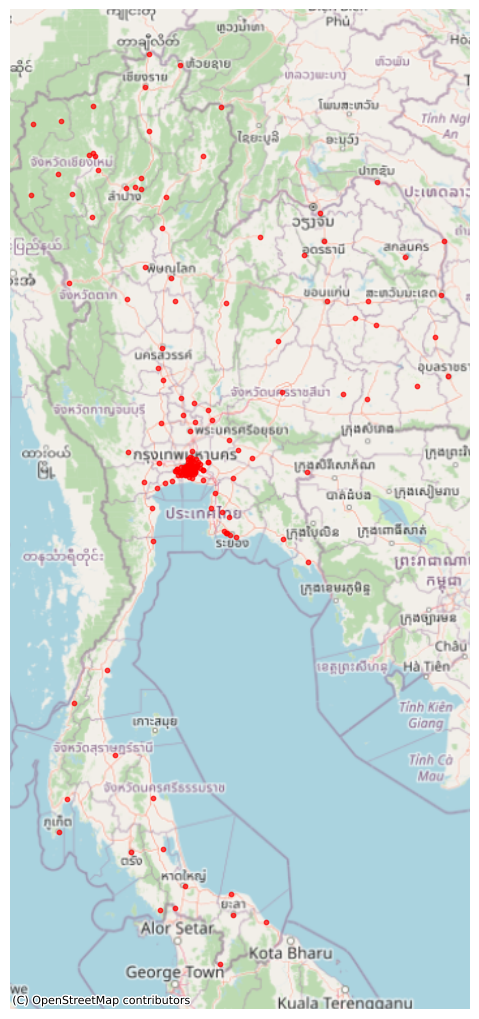

Plot window closed or script finished.


In [89]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import os

def test_map_display_in_window(shp_filepath):
    """
    Tests if a map can be displayed in a pop-up window using plt.show().
    """
    print(f"--- Attempting to display map from {shp_filepath} in a window ---")

    # 1. โหลดข้อมูล Shapefile
    try:
        gdf = gpd.read_file(shp_filepath)
        print(f"SUCCESS: Loaded shapefile: {shp_filepath} with CRS: {gdf.crs}")
    except Exception as e:
        print(f"ERROR: Could not load shapefile '{shp_filepath}': {e}")
        print("Please ensure your shapefile path is correct and all related files (.dbf, .shx, .prj, etc.) are present.")
        return

    # 2. สร้าง figure และ axes
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100) # ใช้ dpi มาตรฐานก่อน
    print("Created matplotlib figure and axes.")

    # 3. Plot ข้อมูลของคุณ (PM2.5)
    try:
        gdf.plot(ax=ax, color="red", markersize=10, alpha=0.7, zorder=2)
        print("SUCCESS: Plotted GeoDataFrame data.")
    except Exception as e:
        print(f"ERROR: Could not plot GeoDataFrame: {e}")
        return

    # 4. เพิ่มแผนที่ฐานจาก Contextily
    try:
        ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
        print("SUCCESS: Added basemap from Contextily.")
    except Exception as e:
        print(f"ERROR: Failed to add basemap (check internet, firewall, or provider): {e}")
        ax.set_title("Map Load Failed. Check Internet/Firewall.")
        ax.set_facecolor('lightgray')
        
    # 5. ปรับแต่ง axes
    ax.set_axis_off()
    plt.tight_layout(pad=0)
    print("Adjusted axis and layout.")

    # 6. แสดงผลกราฟ
    print("Attempting to show plot window. Please wait...")
    plt.show() # <-- บรรทัดสำคัญที่ควรแสดงหน้าต่างกราฟ
    print("Plot window closed or script finished.")

if __name__ == "__main__":
    # ตรวจสอบให้แน่ใจว่าไฟล์ shapefile 'pm25.shp' และไฟล์ประกอบอื่นๆ
    # (เช่น .dbf, .shx, .prj) อยู่ในโฟลเดอร์เดียวกันกับสคริปต์นี้
    shapefile_path = "pm25.shp" 
    
    # ตรวจสอบว่าไฟล์ shapefile มีอยู่จริง
    if not os.path.exists(shapefile_path):
        print(f"ERROR: Shapefile '{shapefile_path}' not found.")
        print("Please ensure the shapefile and its related files are in the same directory as this script.")
    else:
        test_map_display_in_window(shapefile_path)

In [90]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from reportlab.lib.pagesizes import A4, landscape
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch, mm
from reportlab.lib.colors import black, blue, gray
from reportlab.lib.utils import ImageReader
import io
import os 

def generate_static_map_image_from_shp(shp_filepath, output_size_inches=(8, 6)):
    """
    Generates a static map image based on the extent of a given shapefile.
    This version uses the original CRS of the shapefile.
    """
    try:
        gdf = gpd.read_file(shp_filepath)
        print(f"Loaded shapefile: {shp_filepath} with CRS: {gdf.crs}")
    except Exception as e:
        print(f"ERROR: Could not load shapefile '{shp_filepath}': {e}")
        return io.BytesIO()

    # *** เราจะใช้ CRS ดั้งเดิมของ GeoDataFrame โดยตรง ***
    # *** บรรทัดนี้จะถูกคอมเมนต์ออกไปหรือลบไป ***
    # gdf_proj = gdf.to_crs(epsg=3857) 
    # print(f"Projected GeoDataFrame to CRS: {gdf_proj.crs}")
    
    # ใช้ gdf ตัวเดิมสำหรับ plot
    gdf_to_plot = gdf 
    print(f"Using GeoDataFrame with original CRS: {gdf_to_plot.crs}")

    fig, ax = plt.subplots(figsize=output_size_inches, dpi=300) 
    
    # Plot your data (e.g., PM2.5 points)
    # ใช้ gdf_to_plot ที่เป็น gdf ตัวเดิม
    gdf_to_plot.plot(ax=ax, color="red", markersize=10, alpha=0.7, zorder=2) 
    print("Data plotted on map.")

    try:
        # ใช้ CRS ของ gdf_to_plot ซึ่งคือ CRS ดั้งเดิมของ shapefile
        ctx.add_basemap(ax, crs=gdf_to_plot.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
        print("SUCCESS: Basemap added to plot using gdf extent and original CRS.")
    except Exception as e:
        print(f"ERROR: Failed to add basemap (check internet or provider or CRS): {e}")
        ax.set_title(f"Map Load Failed\n({str(e).splitlines()[0]})")
        ax.set_facecolor('lightgray')

    ax.set_axis_off()
    plt.tight_layout(pad=0)

    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig) 
    img_buffer.seek(0) 

    # สำหรับ Debugging: เพื่อให้คุณตรวจสอบไฟล์ภาพที่ถูกสร้างขึ้น
    debug_save_path = "debug_map_output_from_shp.png"
    with open(debug_save_path, 'wb') as f:
        f.write(img_buffer.getvalue())
    print(f"DEBUG: Map saved to {debug_save_path} for inspection.")
    img_buffer.seek(0) 

    return img_buffer

def create_custom_report_template_with_generated_map(
    filename="report_template_generated_map.pdf", 
    pm25_shp_filepath="pm25.shp" # Path to your shapefile
):
    # กำหนดขนาด A4 แนวนอน
    page_width, page_height = landscape(A4)
    c = canvas.Canvas(filename, pagesize=landscape(A4))

    # กำหนดระยะขอบ (margins) เพื่อให้มีพื้นที่รอบๆ เนื้อหา
    margin = 0.5 * inch 
    usable_width = page_width - (2 * margin)
    usable_height = page_height - (2 * margin)

    # --- ส่วนที่ 1: แผนที่ (2/3 ของหน้ากระดาษ) ---
    map_display_width = usable_width * (2/3)
    map_display_height = usable_height
    map_x = margin
    map_y = margin
    
    print(f"DEBUG: Map display area: x={map_x}, y={map_y}, width={map_display_width}, height={map_display_height}")

    # Generate the map image using your shapefile
    map_image_buffer = generate_static_map_image_from_shp(
        shp_filepath=pm25_shp_filepath,
        output_size_inches=(map_display_width / inch, map_display_height / inch)
    )
    
    if map_image_buffer.tell() == 0: 
        print("ERROR: Map image buffer is empty. Map not generated correctly from shapefile.")
        c.setFont("Helvetica-Bold", 16)
        c.setFillColor(black)
        c.drawString(map_x + 50, map_y + map_display_height / 2, "Map Not Available")
        c.drawString(map_x + 50, map_y + map_display_height / 2 - 20, "Check 'pm25.shp' and console for errors.")
    else:
        try:
            map_img_reader = ImageReader(map_image_buffer)
            c.drawImage(map_img_reader, map_x, map_y, width=map_display_width, height=map_display_height)
        except Exception as e:
            print(f"ERROR: Could not draw map image in PDF (ReportLab error): {e}")
            c.setFont("Helvetica-Bold", 16)
            c.setFillColor(black)
            c.drawString(map_x + 50, map_y + map_display_height / 2, "Map Drawing Error")
            c.drawString(map_x + 50, map_y + map_display_height / 2 - 20, f"Error: {e}")

    # Add a title for the map section
    c.setFont("Helvetica-Bold", 14)
    c.drawString(map_x + 10, map_y + map_display_height - 30, "แผนที่ PM2.5 (2/3 ของหน้ากระดาษ)")


    # --- ส่วนที่ 2: คำบรรยาย (1/3 ด้านข้างขวา - ส่วนบน) ---
    description_width = usable_width * (1/3)
    description_x = map_x + map_display_width + margin / 2 
    description_height = usable_height * (3/4) 
    description_y = usable_height - description_height + margin 

    c.setFont("Helvetica-Bold", 16)
    c.setFillColor(blue)
    c.drawString(description_x + 10, description_y + description_height - 30, "รายละเอียด / คำบรรยาย")

    c.setFont("Helvetica", 10)
    c.setFillColor(black)
    description_text = [
        "ข้อมูลเกี่ยวกับคุณภาพอากาศ PM2.5 ในพื้นที่ที่แสดงบนแผนที่.",
        "จุดสีแดงบนแผนที่แสดงตำแหน่งและค่า PM2.5.",
        "ข้อมูลนี้มีความสำคัญต่อการประเมินสุขภาพและสิ่งแวดล้อม.",
        "",
        "คำแนะนำ: ควรตรวจสอบค่า PM2.5 อย่างสม่ำเสมอ",
        "โดยเฉพาะในช่วงที่มีมลพิษสูง และควรป้องกันตนเอง.",
        "",
        "สามารถนำข้อมูลไปใช้ในการวางแผนและตัดสินใจเพื่อ",
        "ปรับปรุงคุณภาพอากาศในระยะยาว."
    ]
    textobject = c.beginText(description_x + 10, description_y + description_height - 50)
    textobject.setFont("Helvetica", 10)
    textobject.setFillColor(black)
    for line in description_text:
        textobject.textLine(line)
    c.drawText(textobject)


    # --- ส่วนที่ 3: เครดิตผู้จัดทำ (1/3 ด้านข้างขวา - ส่วนล่าง) ---
    credit_width = usable_width * (1/3)
    credit_x = description_x 
    credit_height = usable_height * (1/4) 
    credit_y = margin 

    c.setFont("Helvetica-Bold", 12)
    c.setFillColor(black)
    c.drawString(credit_x + 10, credit_y + credit_height - 30, "ผู้จัดทำ:")
    c.setFont("Helvetica", 10)
    c.drawString(credit_x + 10, credit_y + credit_height - 50, "ชื่อ-นามสกุล: คุณเจมินี่ AI")
    c.drawString(credit_x + 10, credit_y + credit_height - 65, "ตำแหน่ง: ผู้ช่วยอัจฉริยะ")
    c.drawString(credit_x + 10, credit_y + credit_height - 80, "วันที่: 12 มิถุนายน 2568")

    c.save()
    print(f"สร้างไฟล์ '{filename}' เรียบร้อยแล้ว")

if __name__ == "__main__":
    create_custom_report_template_with_generated_map(pm25_shp_filepath="pm25.shp")

DEBUG: Map display area: x=36.0, y=36.0, width=513.2598425196851, height=523.2755905511812
Loaded shapefile: pm25.shp with CRS: EPSG:4326
Using GeoDataFrame with original CRS: EPSG:4326
Data plotted on map.
SUCCESS: Basemap added to plot using gdf extent and original CRS.
DEBUG: Map saved to debug_map_output_from_shp.png for inspection.
ERROR: Map image buffer is empty. Map not generated correctly from shapefile.
สร้างไฟล์ 'report_template_generated_map.pdf' เรียบร้อยแล้ว
